In [1]:
from __future__ import print_function
from __future__ import division

import math

import numpy as np
import pandas as pd
from skimage import color
from skimage.transform import resize
from skimage import io, data
from skimage.io import imread_collection
from matplotlib import pyplot as plt
import os
import random
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import VGG19_Weights, VGG19_BN_Weights
import torchmetrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

### WARNING
For Part 1, the outputs that you will see below are found with our limited computation power. To get these outputs in a reasonable time and without any memory or overflow errors, we had to limit all of our computations. Therefore, these outputs belong to three of our handpicked models with a limited number of epochs.

But do not worry. we have prepared this report with zero limitations. That means, if you run all of the code below, you will see the results as they are stated in the assingment pdf. So, all of the graphs and tables will be better at the runtime (when you run the code).

# Problem Overview

    In this assignment, we will perform a image classification with the given "Vegetable" image dataset.
    In Part 1, we will use our own Neural Network implementation.
    In Part 2, we will finetune a pretrained VGG-19 model.
    In the end we will conduct our experiments and compare the results of our experiments.
    Now, we will continue with the explanation of our functions and classes.

 ### def images_to_array(dir_name):

    This function reads our input, converts it to "grayscale" and finally resizes it to 100x100 pixels.

In [2]:
# reads all images from given directory
# returns list of np.arrays
# each row of an np.array represents an image, transformed from rgb to grayscale
# each column of array represents the grayscale value (between 0-1)
# images are resized to be 100x100 pixels
# if you want to see the image, try -> np.reshape(100, 100)
def images_to_array(dir_name):
    ar = []
    labels = []
    directory = dir_name
    for filename in os.listdir("Vegetable Images/"+directory):
        folder = "Vegetable Images/"+directory+"/"+filename+"/*.jpg"
        col = imread_collection(folder)
        for image in col:
            img = color.rgb2gray(image)
            img_resized = resize(img, (100, 100), anti_aliasing=True)
            ar.append(img_resized.flatten())
            labels.append(filename)

    return np.vstack(ar), np.array(labels)

### def one_hot(ar):

    This function converts our output data to corresponding one-hot output. To give an example:

    "Bean" = [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
    
    "Bitter_Gourd" = [0 1 0 0 0 0 0 0 0 0 0 0 0 0]
    
    and it goes on.

In [3]:
def one_hot(ar):
    res = []
    veg = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage',
           'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
    zeros = np.zeros(15, dtype=int)
    for i in ar:
        ind = veg.index(i)
        temp = zeros.copy()
        temp[ind] = 1
        res.append(temp)
    return np.vstack(res)

### class Network:

    Our class to construct the neural network model.
    Since the required implementation must be robust, our model can be created with any numbers of hidden layers and nodes.
    For example:
    model with no hidden layers: [10000, "sigmoid", 15, "softmax", 15]
    model with one hidden layer: [10000, "sigmoid", 225, "tanh", 15, "softmax", 15]
    any combination of functions can be used.
    
        WARNING-1: To apply "softmax" function, please leave the last two layers as [15, "softmax", 15]. In this implementation this expression counts as just the output layer.
        
        WARNING-2: To get the visualization of images from the model, please enter a number that is the square of any number for the layer that is before the output nodes. For example: 100, 121, 169, 196, 225 etc.

### def initialization(self):

    When we create our "Network" object, this function initializes our model with random weights (thetas). As we train our model with the validation set, these numbers will be finetuned.

### def sigmoid(self, z):
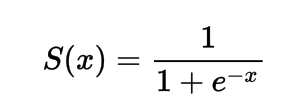

### def dxsigmoid(self, z): y(1 - y)


###  def softmax(self,z):
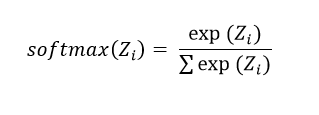

### def relu(self, z):
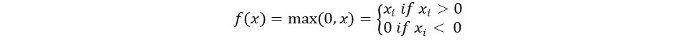

### def dxrelu(self, z):
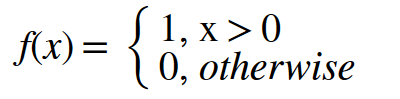

### def tanh(self, z):
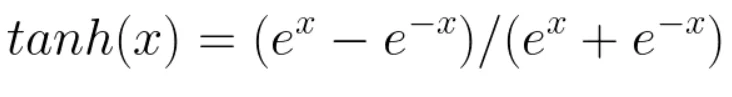

### def dxtanh(self, z):
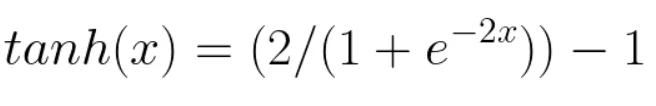

### def forward(self, X):
Function to apply forward propagation.
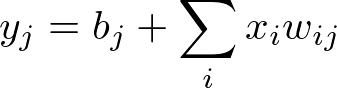

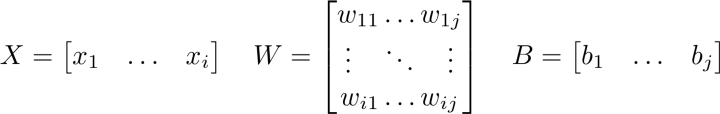

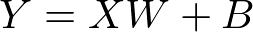

###  def costFunction(self):
To determine the cost, we will use sum of negative log-likelihood of the correct labels.
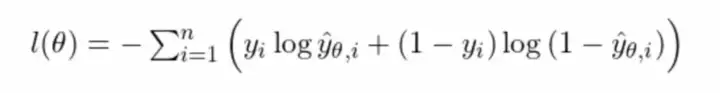

### def gradients(self, X, Y):
We will use the derivatives of the activation functions to calculate every weight and bias with respect to the cost.
(Back Propagation)

### def accuracy(self, X, Y):
Function to calculate the accuracies. This function will be used when we print train and validation accuracies in each epoch.

### def metrics(self, X, Y):
Function to calculate our performance metrics (Accuracy, Precision, Recall, F1-Measure).

NOTE: you can remove the comment lines below it to see the metrics at each epoch.

### def train(self, X, Y, x_test, y_test, isTest = False):
Function to train our model. Firstly, we will use train and validation datasets to train the model. Later on, we will use the train and test datasets to see how well our model works.

NOTE: Use isTest = True when you use the test dataset to see the performance metrics.

In [4]:
class Network:
    def __init__(self, structure, epochs=10, alpha=0.1, batch_size=0, regularizer=0.0):
        #Taking the numbers out of the structure list:
        self.sizes = [x for x in structure if isinstance(x, int)]
        #Taking the activation functions out of the structure list:
        self.activations = [x.lower() for x in structure if isinstance(x, str)]
        #Hiperparameters:
        self.epochs = epochs
        self.alpha = alpha
        self.Reg = regularizer
        self.batch_size = batch_size
        #Initializing Weights and bias into Theta:
        self.Thetas = self.initialization()

    def initialization(self): #Randomly start the weights and bias
        # Randomly initializing Thetas, It will be a dictionary containing the Theta of each layer
        Thetas = {}
        for layer in range(len(self.sizes)-1):
            Thetas[f'T{layer+1}'] = np.random.randn(self.sizes[layer]+1, self.sizes[layer+1])/10
        return Thetas #{T1:[...], T2:[...], T3:[...], ...}

    #ACTIVATION FUNCTIONS:

    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def dxsigmoid(self, z):
        return np.multiply(self.sigmoid(z),(1-self.sigmoid(z)))

    def softmax(self,z):
        z = np.array(z)
        e_x = np.exp(z - np.max(z, axis=1, keepdims=True))
        return (e_x / e_x.sum(axis=1)[:,None])

    def relu(self, z):
        return np.maximum(0,z)

    def dxrelu(self, z):
        return np.where(z >= 0, 1, 0)

    def tanh(self, z):
        return np.tanh(z)

    def dxtanh(self, z):
        return 1 - np.square(np.tanh(z))

    #TRAINING FUNCTIONS:
    def forward(self, X): #forward propagation
        X = np.matrix(X)
        m = X.shape[0]
        att = self.activations
        Thetas = self.Thetas
        forward_steps = {}
        forward_steps['a1'] = X
        Lastlayer = int(len(self.sizes))
        for layer in range(1,Lastlayer):
            forward_steps[f'z{layer+1}'] = np.dot(forward_steps[f'a{layer}'], Thetas[f'T{layer}'])
            if att[layer-1] == 'sigmoid':
                forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.sigmoid(forward_steps[f'z{layer+1}'])), axis=1)
            elif att[layer-1] == 'softmax':
                forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.softmax(forward_steps[f'z{layer+1}'])), axis=1)
            elif att[layer-1] == 'relu':
                forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.relu(forward_steps[f'z{layer+1}'])), axis=1)
            elif att[layer-1] == 'tanh':
                forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.tanh(forward_steps[f'z{layer+1}'])), axis=1)
            else:
                print('ERROR')

        h = forward_steps.pop(f'a{Lastlayer}')
        forward_steps['h'] = h[:,1:]

        return forward_steps

    def costFunction(self):
        Y = self.Y
        X = self.X
        Thetas = self.Thetas
        m = self.m
        Reg = self.Reg
        soma_weights = 0
        for i in range(len(Thetas)):
            weights = Thetas[f'T{i+1}']
            weights[0] = 0
            soma_weights += np.sum(weights**2)
        forward_dict = self.forward(X)
        h = forward_dict['h']
        soma = np.sum((np.multiply(-Y , np.log(h)) - np.multiply((1-Y),(np.log(1-h)))))
        J = soma/m + (Reg/(2*m)) * soma_weights
        return J

    def gradients(self, X, Y):
        X = np.matrix(X)
        Y = np.matrix(Y)
        m = X.shape[0]
        Thetas = self.Thetas
        n_layers = len(self.sizes)
        att = self.activations
        Thetas_grad = []

        forward_list = self.forward(X)
        deltas = {}
        deltas[f'delta{n_layers}'] = forward_list['h'] - Y # derivative of the last layer
        for i in range(n_layers-1,1,-1):# 3 ... 2
            if att[i-2] == 'sigmoid':
                deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxsigmoid(forward_list[f'z{i}']))
            elif att[i-2] == 'relu':
                deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxrelu(forward_list[f'z{i}']))
            elif att[i-2] == 'tanh':
                deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxtanh(forward_list[f'z{i}']))

        for c in range(len(deltas)):#0 ... 1 ... 2
            BigDelta = np.array(np.dot(deltas[f'delta{c+2}'].T, forward_list[f'a{c+1}']))
            weights = Thetas[f'T{c+1}']
            weights[0] = 0
            grad = np.array(BigDelta + (self.Reg * weights.T))/m
            Thetas_grad.append(grad)
        return Thetas_grad #[T1_grad, T2_grad, T3_grad]

    def accuracy(self, X, Y):
        forward_list = self.forward(X)
        h = forward_list['h']
        y_hat = np.argmax(h, axis=1)[:,None]
        y = np.argmax(Y, axis=1)[:,None]
        return np.mean(y_hat == y)

    def metrics(self, X, Y):
        forward_list = self.forward(X)
        h = forward_list['h']
        y_hat = np.argmax(h, axis=1)[:,None]
        y = np.argmax(Y, axis=1)[:,None]
        res = []
        res.append(accuracy_score(y, y_hat))
        res.append(precision_score(y, y_hat, average="macro", zero_division=0))
        res.append(recall_score(y, y_hat, average="macro"))
        res.append(f1_score(y, y_hat, average="macro"))
        res.append(confusion_matrix(y, y_hat))
        return res
        # print("Accuracy: ", accuracy_score(y, y_hat))
        # print("Precision: ", precision_score(y, y_hat, average="macro", zero_division=0))
        # print("Recall: ", recall_score(y, y_hat, average="macro"))
        # print("F1 score: ", f1_score(y, y_hat, average="macro"))
        # print()

    def train(self, X, Y, x_test, y_test, isTest = False):
        Thetas = self.Thetas
        self.X = X
        self.Y = Y
        self.m = X.shape[0]
        j_history = []
        sec1 = time.time()
        if self.batch_size <= 0:
            b_size = self.m
            print(f'Using batch size: {b_size}..')
        elif isinstance(self.batch_size, int) and (1<= self.batch_size <= self.m):
            b_size = self.batch_size
        else:
            return 'ERROR IN BATCH SIZE'
        for ep in range(self.epochs):
            m = self.m
            a = np.array([0,b_size])
            num = 1 #put a higher number if will use lots of epochs
            self.alpha = (1 / 1 + (0.01 * ep)) * self.alpha # decay
            for i in range(m // b_size):
                inx = a + b_size*i
                grad_list = self.gradients(X[inx[0]:inx[1]], Y[inx[0]:inx[1]])
                for g in range(len(grad_list)):
                    self.Thetas[f'T{g+1}'] = self.Thetas[f'T{g+1}'] - self.alpha*np.array(grad_list[g]).T

            if (ep+1) % num == 0: #
                J = self.costFunction()
                j_history.append(J)
                accu_train = self.accuracy(X,Y)
                accu_test = self.accuracy(x_test,y_test)
                sec2 = time.time()
                tempo_gasto = sec2 - sec1 # time spent
                print(f'Epoch: {ep+1}; Cost: {J:.5f}: Accuracy Train: {accu_train:.5%}; Accuracy Test: {accu_test:.5%}; Time Spent: {tempo_gasto:.2f} s')

                if((ep+1) % 10 == 0 and isTest == False):
                    flag = earlystop(j_history[-10:])
                    if(flag):
                        print("Early stop at ", ep+1)
                        break
        if(isTest):
            return j_history, self.Thetas, self.metrics(x_test, y_test)
        else:
            return j_history, self.Thetas

### def earlystop(ar):
Function to apply early stopping method. DFunction takes the cost history as an argument and then takes the last 10 elements. Divides the elements by two as "first5" and "last5" and then compares every element of last5 with first5. If every element of the last5 is bigger than the first5, execution of training stops. This is due to the fact that our cost has absolutely increased in last 10 epochs. Our function checks this increase for every 10 epochs and stops the training if the situation that I explained occurs. It is a function ro avoid overfitting.

In [5]:
def earlystop(ar):
    first5 = ar[:5]
    last5 = ar[-5:]
    res = []
    for i in last5:
        flag = all(i > j for j in first5)
        res.append(flag)
    if(False in res):
        return False
    else:
        return True

### def transform_data(X, Y):
Function to prepare datasets. Converts strings to corresponding one hot output values for train_y, validation_y and test_y.

In [6]:
def transform_data(X, Y):
    m = X.shape[0]       #number of images
    n = X.shape[1] + 1   #number of pixels in each image, +1 because of the bias
    X = np.concatenate((np.ones([m,1]),X), axis=1) # Adding the column of 1's for supporting the bias

    return X, one_hot(Y)

### def graph(ar, model):
Prints the cost history of our model as a graph.

NOTE: the alpha of the model is not the initial one. It is the last final value of alpha. This decrease in alpha value is the result of our "decay rate". It is calculated as:
    
    self.alpha = (1 / 1 + (0.01 * ep)) * self.alpha

In [7]:
def graph(ar, model):
    plt.plot(ar, 'go-',label='Cost')
    plt.title('Cost X Epochs for function: ' + str(model.activations[0]) + " alpha: " + str(round(model.alpha, ndigits=4)) + " batch-size: " + str(model.batch_size))
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

### def visualize(trained_thetas):
Function that transforms model's weights into a visual. It can be used to see the learned visual by the model.

NOTE: It can be used for a single node.

In [8]:
def visualize(trained_thetas):
    # weights = np.sum(trained_thetas["T1"], axis=1)[1:]
    weights = trained_thetas["T1"][1:, 0]
    weights = weights.reshape(100, 100)
    plt.imshow(weights, cmap="gray")
    plt.title("Vegetable")
    plt.show()

###  def get_images(trained_thetas):
Function to transform all of the weights and biases to images. We will use it to transform our learned weights to iamges at the end.

NOTE: It can be used for multiple nodes (all of the output classes).

In [9]:
def get_images(trained_thetas):
    layer = list(trained_thetas.keys())[-2]
    veg = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage',
           'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
    for i in range(len(veg)):
        weights = trained_thetas[layer][1:, i]
        pixel = int(math.sqrt(trained_thetas[layer].shape[0] - 1))
        weights = weights.reshape(pixel, pixel)
        plt.imshow(weights, cmap="gray")
        plt.title(veg[i])
        plt.show()

### def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, isTest = False):
The function trains for the specified number of epochs and after each epoch runs a full validation/testing step. It also keeps track of the best performing model (in terms of validation/testing loss) every 10 epoch and stops the model if loss became higher than previous models loss and saves the previous model as the best performing model. Then it returns the best model and prints out its metrics.

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, isTest = False):
    # Check if we are validating or testing
    if(isTest):
        phaseNext = 'test'
    else:
        phaseNext = 'val'
    
    since = time.time()
    
    val_loss_history = []
    best_metrics = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 999.0
    prev_loss = 999.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Initialize metrics and confusion matrix
        metric_acc = torchmetrics.Accuracy(task='multiclass', average='macro', num_classes=15).to(device)
        metric_pre = torchmetrics.Precision(task='multiclass', average='macro', num_classes=15).to(device)
        metric_rec = torchmetrics.Recall(task='multiclass', average='macro', num_classes=15).to(device)
        metric_f1 = torchmetrics.F1Score(task='multiclass', average='macro', num_classes=15).to(device)
        metric_cm = torchmetrics.ConfusionMatrix(task='multiclass', average='macro', num_classes=15).to(device)

        # Each epoch has a training and validation/test phase
        for phase in ['train', phaseNext]:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                       
                # metrics on current batch
                acc = metric_acc(preds, labels.data)
                pre = metric_pre(preds, labels.data)
                rec = metric_rec(preds, labels.data)
                f1 = metric_f1(preds, labels.data)
                cm = metric_cm(preds, labels.data)
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    
            # metrics on all batches using custom accumulation
            # and reseting internal state such that metric ready for new data
            acc = metric_acc.compute()
            metric_acc.reset()
            
            pre = metric_pre.compute()
            metric_pre.reset()
            
            rec = metric_rec.compute()
            metric_rec.reset()
        
            f1 = metric_f1.compute()
            metric_f1.reset()
            
            cm = metric_cm.compute()
            metric_cm.reset()
            
            
            # deep copy the model for every 10 epochs and if new model loss is better than previous model
            if phase == phaseNext and (epoch+1)%10 == 0:
                prev_loss = best_loss
                best_loss = epoch_loss
                best_acc = epoch_acc     
                    
            # save current model as best model and if testing save metrics of new model
            if phase == phaseNext and best_loss < prev_loss and (epoch+1)%10 == 0:
                best_model_wts = copy.deepcopy(model.state_dict())
                if(isTest):
                    best_metrics.clear()
                    best_metrics.append(acc)
                    best_metrics.append(pre)
                    best_metrics.append(rec)
                    best_metrics.append(f1)
                    best_metrics.append(cm.cpu().numpy())
                    
                
            if phase == phaseNext:
                val_loss_history.append(epoch_loss)
                
                
        print()
        
        # early stopping when new model loss is worse than previous model 
        if (epoch+1)%10 == 0 and best_loss > prev_loss and isTest == False:
            print("Early stop at ", epoch+1)
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print()
    if(isTest):
        print(f"Accuracy on all data: {best_metrics[0]}")
        print(f"Precision on all data: {best_metrics[1]}")
        print(f"Recall on all data: {best_metrics[2]}")
        print(f"F1 score on all data: {best_metrics[3]}")
        print("Confusion matrix on all data:")
        print(best_metrics[4])

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history

### def set_parameter_requires_grad(model, feature_extracting):

This function sets the ".requires_grad" attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients.

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### def initialize_model(num_classes, feature_extract):

This function reshapes the last layer of the VGG19 model to have the same number of inputs as before, and to have the same number of outputs as the number of classes in the dataset.

In [12]:
def initialize_model(num_classes, feature_extract):
    model_ft = models.vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    return model_ft

### def get_params_to_update(model, feature_extracting):

This function gathers the parameters to be optimized/updated in this run. If we are finetuning we will be updating all parameters. However, if we are doing feature extract method, we will only update the parameters that we have just initialized.

In [13]:
def get_params_to_update(model, feature_extracting):
    params_to_update = model.parameters()
    
    if feature_extracting:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
    
    return params_to_update

### def graph_cnn(hist, isTest):

This function prints a graph of models loss history for part 2.

In [14]:
def graph_cnn(hist, isTest):
    if (isTest):
        case = "Feature Extraction"
    else:
        case = "Finetune"
    plt.plot(hist, 'go-',label='Loss')
    plt.title('Loss X Epochs for '+case)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

### def visualize_cnn(model, images):

This function visualizes feature maps(activation maps) in our CNN model. But for practicality, this function only shows visualization of last layer.

In [32]:
def visualize_cnn(model, images):
    no_of_layers=0
    conv_layers=[]
 
    model_children=list(model.cpu().children())
 
    for child in model_children:
        if type(child)==nn.Conv2d:
            no_of_layers+=1
            conv_layers.append(child)
        elif type(child)==nn.Sequential:
            for layer in child.children():
                if type(layer)==nn.Conv2d:
                    no_of_layers+=1
                    conv_layers.append(layer)
            
    class_index = 0
    for img in images:
        results = [conv_layers[0](img)]
        for i in range(1, len(conv_layers)):
            results.append(conv_layers[i](results[-1]))
        outputs = results
        num_layer = 15
        plt.figure(figsize=(10, 2))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print(class_names[class_index])
        for i, filter in enumerate(layer_viz):
            if i == 16: 
                break
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
        plt.show()
        plt.close()
        class_index += 1

# PART 1

We will read our data from "Vegetable" dataset.

In [16]:
# PART 1
# read images and convert them from rgb to grayscale
print("Reading data starts...")
train_x, train_y = images_to_array("train")
test_x, test_y = images_to_array("test")
validation_x, validation_y = images_to_array("validation")
print("Reading data ended.")

Reading data starts...
Reading data ended.


We will transform our data for our model. 

For our experiments, we will have 4 different parameters and 3 values for each parameter. This will result in 3^4 = 81 different variations of models. We will take the best performing models for each kind of "structure" parameter and then compare the results. 

In [17]:
train_x, train_y = transform_data(train_x, train_y)
validation_x, validation_y = transform_data(validation_x, validation_y)
test_x, test_y = transform_data(test_x, test_y)

# parameters = structure (no-hidden layer, 1-hidden, 2-hiddden),
# activation function (sigmoid, relu, tanh),
# alpha (low = 0.005, mid = 0.0125, high = 0.02),
# batch-size (low = 16, mid = 72, high = 128)
cases = {
    "activation": ["sigmoid", "relu", "tanh"],
    "alpha": [0.005, 0.0125, 0.02],
    "batch": [16, 72, 128]}

# model = Network([10000, "sigmoid", 225, "sigmoid", 15, "softmax", 15], epochs=10, alpha=0.02, batch_size=128)
# j_history, trained_thetas = model.train(test_x, test_y, validation_x, validation_y)
# j_history, trained_thetas = model.train(train_x, train_y, validation_x, validation_y)
# graph(j_history, model)
# visualize(trained_thetas)
# get_images(trained_thetas)

Now, we will will perform our experiments with the parameters that I stated above. You can check all of the costs and train and relative accuracies if you check the prints below. At the end of each variation, a graph about "Cost X Epochs" will be printed. Keep in mind that our early stopping method checks for the loss at the end of every 10 epochs. So if the cost of epochs increases, traning will stop at that number of epoch (it will be printed as a message like: early stop at "X"). Ideally, the graph would logarithmically decrease. Since early stopping function activates at every 10 turns, graph could increase at the last 10 turns before it stops.  

Epoch: 1; Cost: 7.15960: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 5.12 s
Epoch: 2; Cost: 6.67668: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 10.19 s
Epoch: 3; Cost: 6.30364: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 15.53 s
Epoch: 4; Cost: 6.67222: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 20.83 s
Epoch: 5; Cost: 6.63806: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 25.97 s
Epoch: 6; Cost: 6.75646: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 31.48 s
Epoch: 7; Cost: 6.53207: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 36.44 s
Epoch: 8; Cost: 6.34362: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 41.74 s
Epoch: 9; Cost: 7.29949: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 47.33 s
Epoch: 10; Cost: 7.44979: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 52.53 s
Epoch: 11; Cost: 8.00145: Accuracy Train

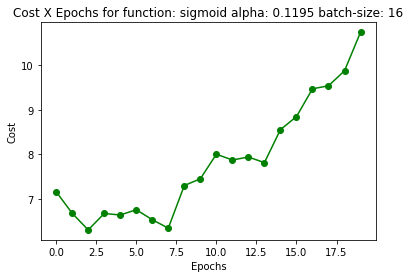

Epoch: 1; Cost: 3.88677: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 17.23 s
Epoch: 2; Cost: 3.81393: Accuracy Train: 6.67333%; Accuracy Test: 6.66667%; Time Spent: 34.80 s
Epoch: 3; Cost: 3.99301: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 52.13 s
Epoch: 4; Cost: 3.97931: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 68.97 s
Epoch: 5; Cost: 3.95265: Accuracy Train: 6.68000%; Accuracy Test: 6.70000%; Time Spent: 86.21 s
Epoch: 6; Cost: 3.94096: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 103.68 s
Epoch: 7; Cost: 3.98277: Accuracy Train: 8.24000%; Accuracy Test: 8.26667%; Time Spent: 120.87 s
Epoch: 8; Cost: 4.06273: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 137.84 s
Epoch: 9; Cost: 4.11954: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 154.78 s
Epoch: 10; Cost: 4.14448: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 172.01 s
Epoch: 11; Cost: 4.15040: Accuracy

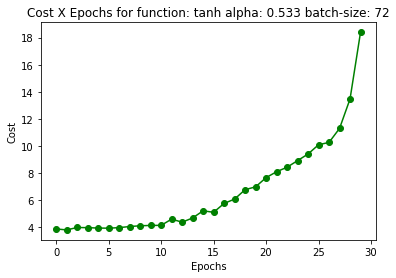

Epoch: 1; Cost: 4.59017: Accuracy Train: 6.66000%; Accuracy Test: 6.66667%; Time Spent: 12.69 s
Epoch: 2; Cost: 8.28213: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 25.16 s
Epoch: 3; Cost: 3.96193: Accuracy Train: 6.69333%; Accuracy Test: 6.66667%; Time Spent: 38.17 s
Epoch: 4; Cost: 4.63253: Accuracy Train: 6.66667%; Accuracy Test: 6.63333%; Time Spent: 50.75 s
Epoch: 5; Cost: 3.67223: Accuracy Train: 8.05333%; Accuracy Test: 7.56667%; Time Spent: 63.03 s
Epoch: 6; Cost: 3.66897: Accuracy Train: 8.86667%; Accuracy Test: 8.43333%; Time Spent: 75.78 s
Epoch: 7; Cost: 4.05781: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 88.45 s
Epoch: 8; Cost: 6.05586: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 100.95 s
Epoch: 9; Cost: 7.01800: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 112.77 s
Epoch: 10; Cost: 4.07949: Accuracy Train: 6.52000%; Accuracy Test: 5.73333%; Time Spent: 126.25 s
Epoch: 11; Cost: 8.52564: Accuracy T

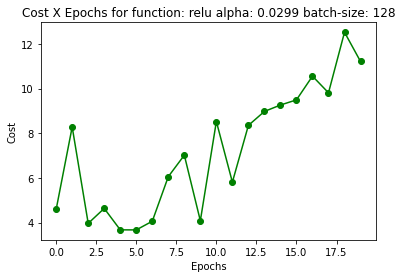

In [18]:
nn_models = {"no-layer":"", "1-layer":"", "2-layer":""}
min_cost = [999, 999, 999]
thetas = np.array([{},{},{}])

for func in cases["activation"]:
    for alpha in cases["alpha"]:
        for batch_size in cases["batch"]:
            model1 = Network([10000, func, 15, "softmax", 15], epochs=100, alpha=alpha, batch_size=batch_size)
            j_history1, trained_thetas1 = model1.train(train_x, train_y, validation_x, validation_y)
            if(j_history1[-1] < min_cost[0]):
                min_cost[0] = j_history1[-1]
                nn_models["no-layer"] = model1
                thetas[0] = trained_thetas1
            graph(j_history1, model1)

            model2 = Network([10000, func,225, func, 15, "softmax", 15], epochs=100, alpha=alpha, batch_size=batch_size)
            j_history2, trained_thetas2 = model2.train(train_x, train_y, validation_x, validation_y)
            if(j_history2[-1] < min_cost[1]):
                min_cost[1] = j_history2[-1]
                nn_models["1-layer"] = model2
                thetas[1] = trained_thetas2
            graph(j_history2, model2)

            model3 = Network([10000, func,500, func, 225, func, 15, "softmax", 15], epochs=100, alpha=alpha, batch_size=batch_size)
            j_history3, trained_thetas3 = model3.train(train_x, train_y, validation_x, validation_y)
            if(j_history3[-1] < min_cost[2]):
                min_cost[2] = j_history3[-1]
                nn_models["2-layer"] = model3
                thetas[2] = trained_thetas3
            graph(j_history3, model3)

# model = Network([10000, "sigmoid", 15, "softmax", 15], epochs=30, alpha=0.02, batch_size=16)
# j_history, trained_thetas = model.train(train_x, train_y, validation_x, validation_y)
# graph(j_history, model)

# model2 = Network([10000, "tanh",225, "tanh", 15, "softmax", 15], epochs=30, alpha=0.01, batch_size=72)
# j_history2, trained_thetas2 = model2.train(train_x, train_y, validation_x, validation_y)
# graph(j_history2, model2)

# model3 = Network([10000, "relu",225, "relu", 225, "relu", 15, "softmax", 15], epochs=30, alpha=0.005, batch_size=128)
# j_history3, trained_thetas3 = model3.train(train_x, train_y, validation_x, validation_y)
# graph(j_history3, model3)

# thetas[0] = trained_thetas
# thetas[1] = trained_thetas2
# thetas[2] = trained_thetas3

# nn_models["no-layer"] = model
# nn_models["1-layer"] = model2
# nn_models["2-layer"] = model3

At this point, we have successfully trained 81 variations of neural network network models and chosen the best 3 performing model of each structure (no-hidden layer, 1-layer, 2-layers). Now, we will use our test dataset and get the performance metrics for our models. Besides of printing cost and accuracy for all epochs, we will also print confusion matrix for each of the models and finally print our table for performance metrics. 

Epoch: 1; Cost: 10.74726: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 5.77 s
Epoch: 2; Cost: 10.77620: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 11.83 s
Epoch: 3; Cost: 10.80897: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 17.54 s
Epoch: 4; Cost: 10.87547: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 23.65 s
Epoch: 5; Cost: 10.95472: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 29.89 s
Epoch: 6; Cost: 11.05308: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 36.45 s
Epoch: 7; Cost: 10.67896: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 42.65 s
Epoch: 8; Cost: 10.79300: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 48.83 s
Epoch: 9; Cost: 11.17220: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 54.68 s
Epoch: 10; Cost: 11.38035: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 60.46 s
Epoch: 11; Cost: 11.64488: Acc

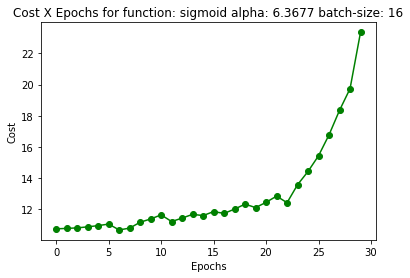

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]]
Epoch: 1; Cost: 7.51681: Accuracy Train: 6.66667%; Acc

C:\Users\furka\AppData\Local\Temp\ipykernel_19348\2887463652.py:87: RuntimeWarning: divide by zero encountered in log
  soma = np.sum((np.multiply(-Y , np.log(h)) - np.multiply((1-Y),(np.log(1-h)))))
C:\Users\furka\AppData\Local\Temp\ipykernel_19348\2887463652.py:87: RuntimeWarning: invalid value encountered in multiply
  soma = np.sum((np.multiply(-Y , np.log(h)) - np.multiply((1-Y),(np.log(1-h)))))


Epoch: 30; Cost: nan: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 532.59 s


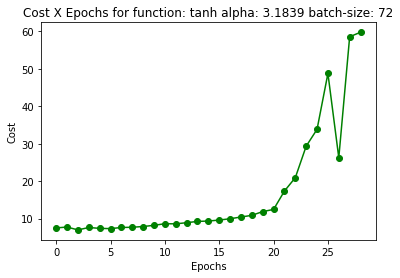

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 200]]


C:\Users\furka\AppData\Local\Temp\ipykernel_19348\2887463652.py:87: RuntimeWarning: divide by zero encountered in log
  soma = np.sum((np.multiply(-Y , np.log(h)) - np.multiply((1-Y),(np.log(1-h)))))


Epoch: 1; Cost: inf: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 10.93 s
Epoch: 2; Cost: 3.67416: Accuracy Train: 6.54667%; Accuracy Test: 6.50000%; Time Spent: 21.67 s
Epoch: 3; Cost: 3.67394: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 32.50 s
Epoch: 4; Cost: 3.67395: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 43.39 s
Epoch: 5; Cost: 3.67393: Accuracy Train: 6.68000%; Accuracy Test: 6.70000%; Time Spent: 54.21 s
Epoch: 6; Cost: 3.67395: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 65.46 s
Epoch: 7; Cost: 3.67395: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 76.88 s
Epoch: 8; Cost: 3.67395: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 87.74 s
Epoch: 9; Cost: 3.67395: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 99.17 s
Epoch: 10; Cost: 3.67395: Accuracy Train: 6.66667%; Accuracy Test: 6.66667%; Time Spent: 110.81 s
Epoch: 11; Cost: 3.67395: Accuracy Train: 

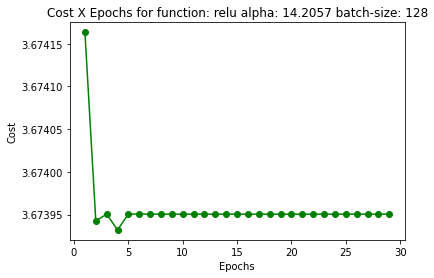

[[200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


,Accuracy,Precision,Recall,F1 Score
no-layer,0.066667,0.004444,0.066667,0.008333
1-layer,0.066667,0.004444,0.066667,0.008333
2-layer,0.066667,0.004444,0.066667,0.008333


In [19]:
np.save("thetas.npy", thetas)
metric_results=[]
for model in nn_models.values():
    j_history, trained_thetas, mets = model.train(train_x, train_y, test_x, test_y, isTest=True)
    graph(j_history, model)
    print(mets[4])
    mets = mets[:4]
    metric_results.append(mets)
mux = pd.MultiIndex.from_product([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
dict_res = {"no-layer":metric_results[0], "1-layer":metric_results[1], "2-layer":metric_results[2]}
df_res = pd.DataFrame.from_dict(dict_res, orient='index', columns = mux)
df_res.head()

Lastly, we will visualize our models' learned weights. We can see that how our models interpret each class according to its learned weights. Below, you can see an example for each of the output classes. 

Visualization of classes for model 1


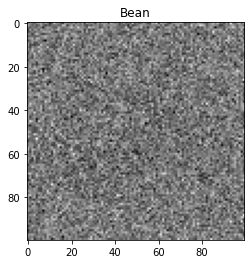

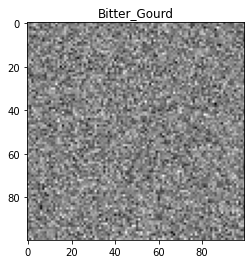

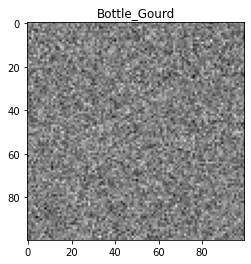

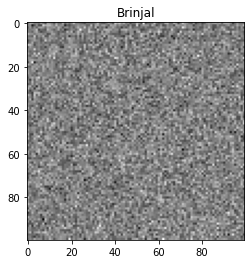

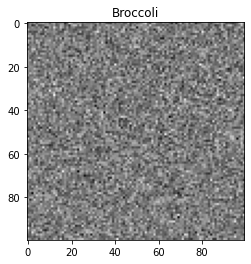

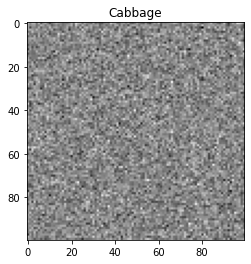

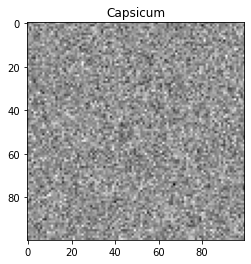

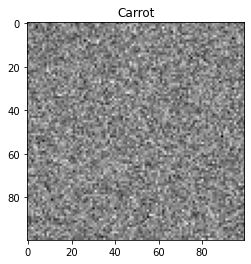

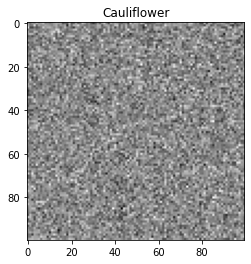

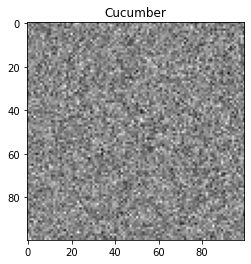

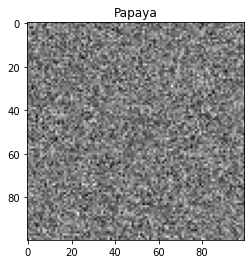

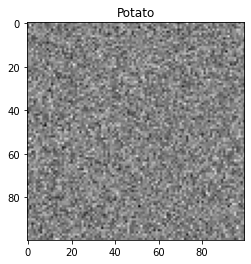

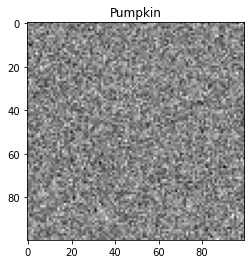

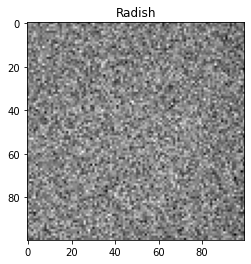

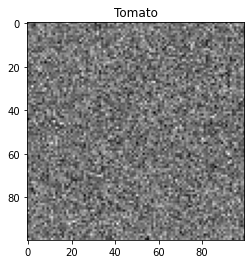

In [20]:
thetas = np.load("thetas.npy", allow_pickle=True)

print("Visualization of classes for model 1")
get_images(thetas[0])

Visualization of classes for model 2


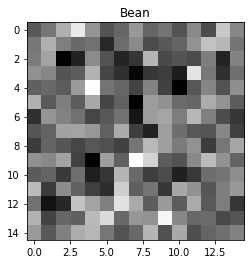

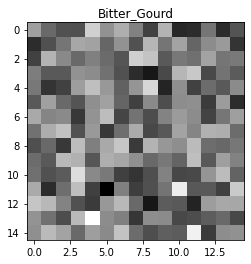

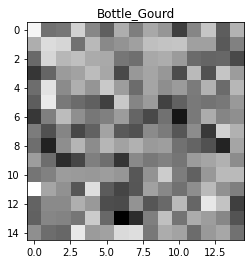

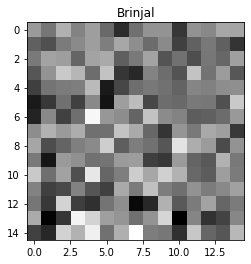

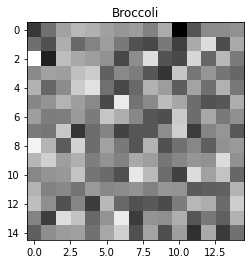

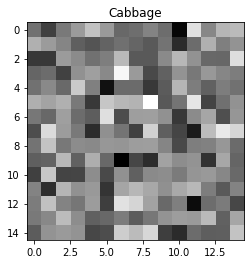

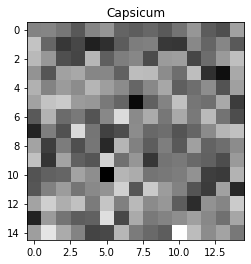

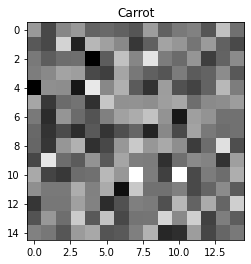

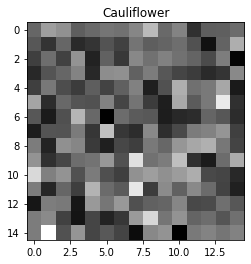

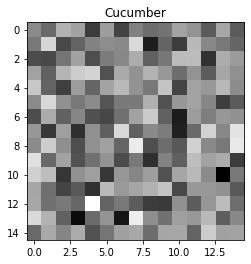

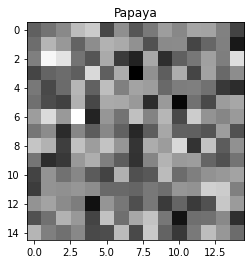

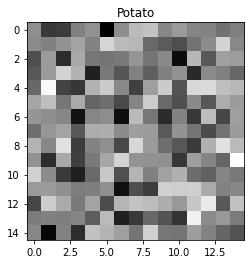

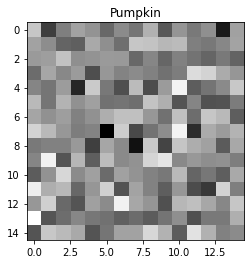

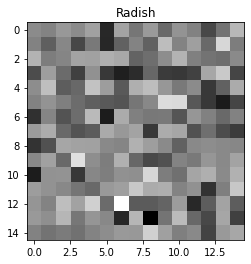

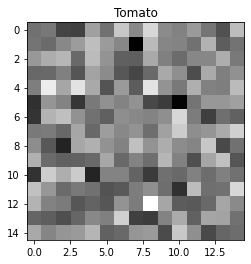

In [21]:
print("Visualization of classes for model 2")
get_images(thetas[1])

Visualization of classes for model 3


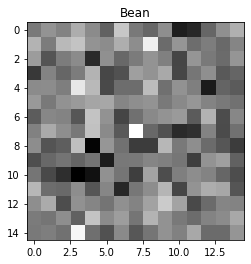

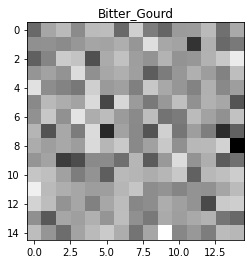

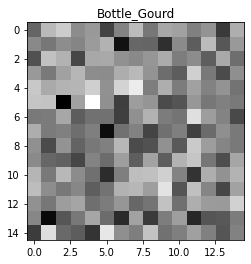

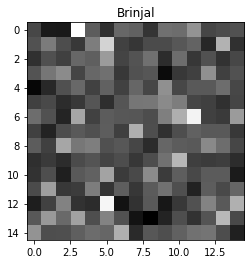

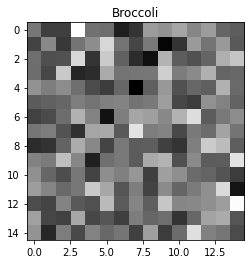

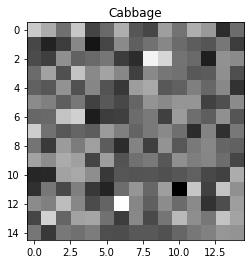

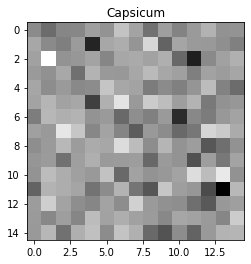

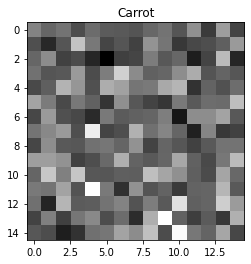

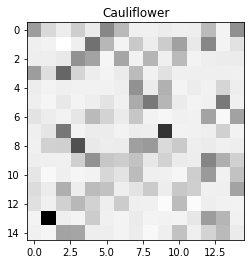

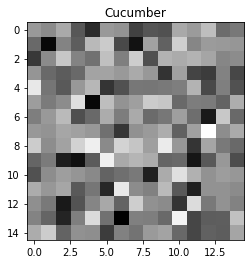

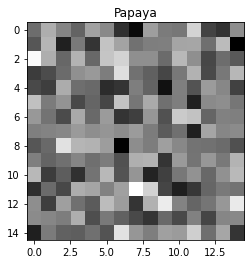

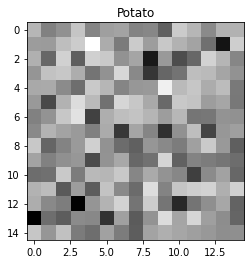

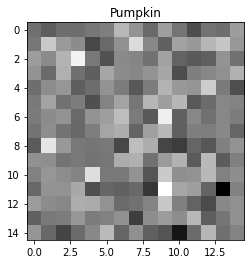

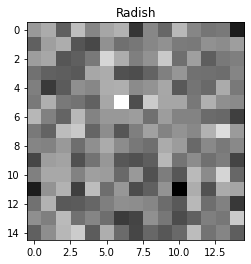

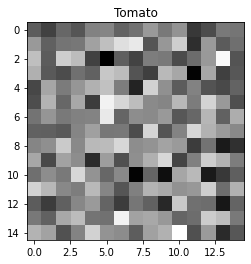

In [22]:
print("Visualization of classes for model 3")
get_images(thetas[2])

## Result analysis for Part 1

We have experimented on 4 different parameters (structure, activation function, alpha, batch size) with 3 different attributes and thus get 81 different variation of models. Based on our experiments here are the results that we concluded:
    
You can see the effect of the structure (number of layers and the number of nodes) clearly when you check the "Cost X Epochs" graphs in the training of models. When we look at the no-layer structure, cost of the model is higher than other two models and it tends to overfit earlier. When we increase the number of layers and nodes in our model, the cost is smaller and it tends to overfit in a later stage of learning. However, when we increase the number of hidden layers and nodes in our model, the execution time of the code is getting bigger, therefore the learning is much more slower than the no-hidden layer structure. We can also observe this type of behavior when we decrease the number of batch size. If we take the high batch size (high = 128), the execution of the code is faster and therefore the learning is faster but if we decrease it, the code takes a longer time to execute.
    
 Alpha value is another important parameter when we train our model. Choosing it at the lowest value (0.005) makes our model converge in a long time. However, if we choose a high value (0.02 or higher) it might overshoot and never converge. To prevent this issue, we use "decay rate" for our alpha value. Because of decay rate, our alpha value is getting smaller and smaller in each epoch, thus our model will never overshoot and it will most likely converge to a final state. You can also check it in the "Cost X Epochs" graphs in the training of our models.
    
Batch size is similar to alpha if we think about it. When we choose the max value (128), model will learn faster but the finetuning proccess might be a bit worse when we choose our batch size as 16. As you can observe, choosing the batch size as 16 makes our learning slower, but the weights of our model will be well finetuned.
    
In the end, there will always be a trade-off between time and performance. If you want our model to perform well regardless of time, you should choose a model with more number of hidden layers and nodes, low alpha and low batch size. On the other hand, if you want faster execution, you should choose a model with no hidden layers, high alpha, and high batch size. Ideally, you should choose a model between these two options. As we stated in the beginning of our report, due to low computational power that our computers have, we had to choose a model that would perform faster rather than higher performance. Also we had to limit our dataset but again, when we sent you this report, all of the limiters that I stated will be removed. So, you can see the results and performances as intended.

# Part 2

At first, we will determine our parameters for learning and testing our models.

In [16]:
# PART 2

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./Vegetable Images"

# Number of classes in the dataset
num_classes = 15

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Custom input size for our model
input_size = 100

In this part, we will transform our "Vegetable Images" dataset to fit our pretrained VGG-19 model. We will change the input size to fit 100x100 pixels and turn it to grayscale. Also we the program checks if the user has GPU on his device, if so the model will finetune itself using GPU. If not, the model will continue with the CPU.

In [17]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Initializing Datasets and Dataloaders...")
# Create training and validation datasets
image_datasets = {"train": datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"]),
                    "val": datasets.ImageFolder(os.path.join(data_dir, "validation"), data_transforms["val"]),
                    "test": datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["val"])}

# Get class names
class_names = image_datasets['train'].classes

# Limit the data size to %10 of original size
reduced_train = []
reduced_val = []
for i in range(15):
    reduced_train.extend(range(i*1000,i*1000+ 100))
    reduced_val.extend(range(i*200,i*200+ 20))
    
image_datasets["train"] = torch.utils.data.Subset(image_datasets["train"], reduced_train)
image_datasets["val"] = torch.utils.data.Subset(image_datasets["val"], reduced_val)
image_datasets["test"] = torch.utils.data.Subset(image_datasets["test"], reduced_val)

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In this part, we will prepare for the visualization process. We will get the weights from our filters and display them with a image from dataset to show that how our model percieves the incoming image input.

In [27]:
# Get specific images from test file and transform them to use in visualization
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(100),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Get only first images of every class
images = []
for filename in os.listdir("Vegetable Images/test/"):
    for imgname in os.listdir("Vegetable Images/test/"+filename):
        img = io.imread("./Vegetable Images/test/"+filename+"/"+imgname)
        img = np.array(img)
        img = transform(img)
        img = img.unsqueeze(0)
        images.append(img)
        break

In this and following parts we finetune the weights of all layers of our model and print several metrics, visualize our model and plot a graph on models loss history.

In [19]:
# Initialize the model for this run
model_ft = initialize_model(num_classes, feature_extract)

# Send the model to GPU
model_ft = model_ft.to(device)

# Get parameters to update in model
params_to_update = get_params_to_update(model_ft, feature_extract)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.005, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate for finetune
model_ft, hist_ft = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 1.2906 Acc: 0.6013
val Loss: 1.1220 Acc: 0.6633

Epoch 1/29
----------
train Loss: 0.6660 Acc: 0.7993
val Loss: 0.8659 Acc: 0.7367

Epoch 2/29
----------
train Loss: 0.5744 Acc: 0.8220
val Loss: 0.3854 Acc: 0.8833

Epoch 3/29
----------
train Loss: 0.4446 Acc: 0.8700
val Loss: 0.4611 Acc: 0.8900

Epoch 4/29
----------
train Loss: 0.4508 Acc: 0.8700
val Loss: 0.2907 Acc: 0.9100

Epoch 5/29
----------
train Loss: 0.4019 Acc: 0.8860
val Loss: 0.3284 Acc: 0.9033

Epoch 6/29
----------
train Loss: 0.3655 Acc: 0.8947
val Loss: 0.4471 Acc: 0.8667

Epoch 7/29
----------
train Loss: 0.2840 Acc: 0.9180
val Loss: 0.3191 Acc: 0.9100

Epoch 8/29
----------
train Loss: 0.3004 Acc: 0.9140
val Loss: 0.2957 Acc: 0.9067

Epoch 9/29
----------
train Loss: 0.2718 Acc: 0.9167
val Loss: 0.2109 Acc: 0.9367

Epoch 10/29
----------
train Loss: 0.2579 Acc: 0.9280
val Loss: 0.3703 Acc: 0.8900

Epoch 11/29
----------
train Loss: 0.2430 Acc: 0.9327
val Loss: 0.1611 Acc: 0.9600

Ep

In [20]:
torch.cuda.empty_cache()

# Test for finetune
model_ft_test, hist_ft_test = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, isTest = True)

Epoch 0/29
----------
train Loss: 0.2667 Acc: 0.9293
test Loss: 0.4097 Acc: 0.8933

Epoch 1/29
----------
train Loss: 0.2116 Acc: 0.9340
test Loss: 0.1712 Acc: 0.9367

Epoch 2/29
----------
train Loss: 0.1896 Acc: 0.9433
test Loss: 0.2167 Acc: 0.9233

Epoch 3/29
----------
train Loss: 0.2798 Acc: 0.9147
test Loss: 0.3344 Acc: 0.9000

Epoch 4/29
----------
train Loss: 0.2025 Acc: 0.9420
test Loss: 0.2022 Acc: 0.9233

Epoch 5/29
----------
train Loss: 0.1906 Acc: 0.9433
test Loss: 0.2225 Acc: 0.9367

Epoch 6/29
----------
train Loss: 0.2109 Acc: 0.9340
test Loss: 0.3175 Acc: 0.9067

Epoch 7/29
----------
train Loss: 0.1900 Acc: 0.9493
test Loss: 0.1950 Acc: 0.9533

Epoch 8/29
----------
train Loss: 0.1650 Acc: 0.9520
test Loss: 0.1929 Acc: 0.9500

Epoch 9/29
----------
train Loss: 0.1765 Acc: 0.9480
test Loss: 0.2737 Acc: 0.9067

Epoch 10/29
----------
train Loss: 0.1711 Acc: 0.9447
test Loss: 0.1365 Acc: 0.9500

Epoch 11/29
----------
train Loss: 0.1410 Acc: 0.9573
test Loss: 0.1947 Acc

Bean


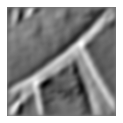

Bitter_Gourd


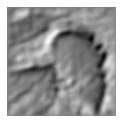

Bottle_Gourd


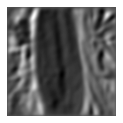

Brinjal


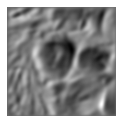

Broccoli


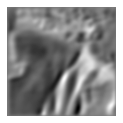

Cabbage


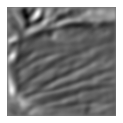

Capsicum


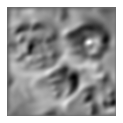

Carrot


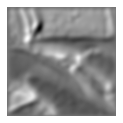

Cauliflower


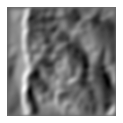

Cucumber


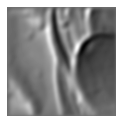

Papaya


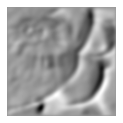

Potato


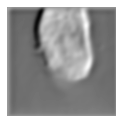

Pumpkin


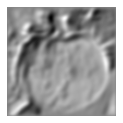

Radish


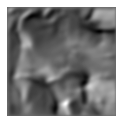

Tomato


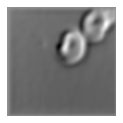

In [33]:
visualize_cnn(model_ft_test, images)

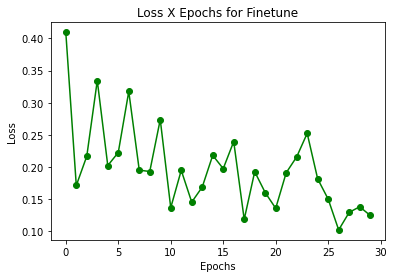

In [34]:
graph_cnn(hist_ft_test, feature_extract)

In this and following parts we finetune the weights of last two fully connected layers of our model(feature extracting) and print several metrics, visualize our model and plot a graph on models loss history.

In [35]:
torch.cuda.empty_cache()

feature_extract = True

# Initialize the model for this run
model_fe = initialize_model(num_classes, feature_extract)

# Send the model to GPU
model_fe = model_fe.to(device)

# Get parameters to update in model
params_to_update = get_params_to_update(model_fe, feature_extract)

# Observe that all parameters are being optimized
optimizer_fe = optim.SGD(params_to_update, lr=0.005, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate for feature extract
model_fe, hist_fe = train_model(model_fe, dataloaders_dict, criterion, optimizer_fe, num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 1.4158 Acc: 0.5640
val Loss: 0.6608 Acc: 0.8200

Epoch 1/29
----------
train Loss: 0.8002 Acc: 0.7580
val Loss: 0.4987 Acc: 0.8600

Epoch 2/29
----------
train Loss: 0.6809 Acc: 0.7813
val Loss: 0.4690 Acc: 0.8533

Epoch 3/29
----------
train Loss: 0.6722 Acc: 0.7873
val Loss: 0.4275 Acc: 0.8900

Epoch 4/29
----------
train Loss: 0.6289 Acc: 0.8040
val Loss: 0.3878 Acc: 0.9000

Epoch 5/29
----------
train Loss: 0.6429 Acc: 0.7873
val Loss: 0.3906 Acc: 0.9067

Epoch 6/29
----------
train Loss: 0.6034 Acc: 0.8047
val Loss: 0.4008 Acc: 0.8967

Epoch 7/29
----------
train Loss: 0.6361 Acc: 0.7987
val Loss: 0.4329 Acc: 0.8833

Epoch 8/29
----------
train Loss: 0.5959 Acc: 0.8127
val Loss: 0.3683 Acc: 0.9067

Epoch 9/29
----------
train Loss: 0.5733 Acc: 0.8173
val Loss: 0.3962 Acc: 0.9067

Epoch 10/29
----------
train Loss: 0.5809 Acc: 0.8147
val Loss: 0.4076 Acc: 0.8933

Epoch 11/29
----------
train Loss: 0.5819 Acc: 0.8207
val Loss: 0.3773 Acc: 0.8933

Ep

In [37]:
torch.cuda.empty_cache()

# Test for feature extract
model_fe_test, hist_fe_test = train_model(model_fe, dataloaders_dict, criterion, optimizer_fe, num_epochs=num_epochs, isTest = True)

Epoch 0/29
----------
train Loss: 0.5054 Acc: 0.8360
test Loss: 0.3102 Acc: 0.9100

Epoch 1/29
----------
train Loss: 0.5788 Acc: 0.8340
test Loss: 0.3128 Acc: 0.9200

Epoch 2/29
----------
train Loss: 0.4815 Acc: 0.8460
test Loss: 0.3103 Acc: 0.9100

Epoch 3/29
----------
train Loss: 0.5516 Acc: 0.8453
test Loss: 0.3107 Acc: 0.9067

Epoch 4/29
----------
train Loss: 0.5140 Acc: 0.8553
test Loss: 0.3361 Acc: 0.9033

Epoch 5/29
----------
train Loss: 0.5193 Acc: 0.8580
test Loss: 0.3430 Acc: 0.9033

Epoch 6/29
----------
train Loss: 0.5312 Acc: 0.8447
test Loss: 0.4033 Acc: 0.8833

Epoch 7/29
----------
train Loss: 0.5161 Acc: 0.8407
test Loss: 0.3539 Acc: 0.8933

Epoch 8/29
----------
train Loss: 0.5500 Acc: 0.8440
test Loss: 0.2707 Acc: 0.9100

Epoch 9/29
----------
train Loss: 0.5204 Acc: 0.8387
test Loss: 0.2928 Acc: 0.9167

Epoch 10/29
----------
train Loss: 0.5866 Acc: 0.8413
test Loss: 0.3652 Acc: 0.8900

Epoch 11/29
----------
train Loss: 0.5096 Acc: 0.8433
test Loss: 0.3252 Acc

Bean


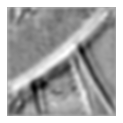

Bitter_Gourd


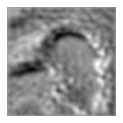

Bottle_Gourd


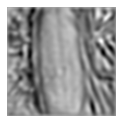

Brinjal


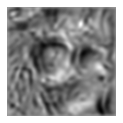

Broccoli


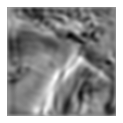

Cabbage


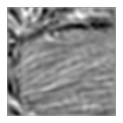

Capsicum


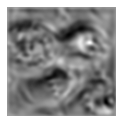

Carrot


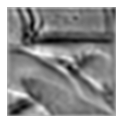

Cauliflower


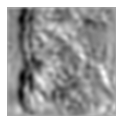

Cucumber


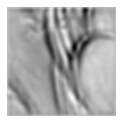

Papaya


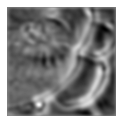

Potato


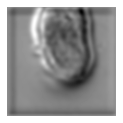

Pumpkin


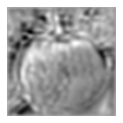

Radish


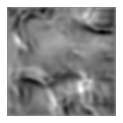

Tomato


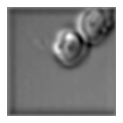

In [38]:
visualize_cnn(model_fe_test, images)

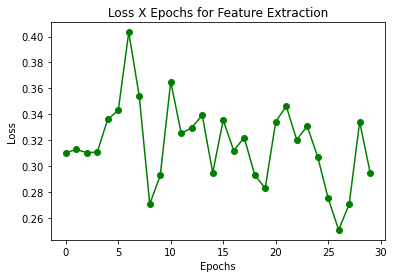

In [39]:
graph_cnn(hist_fe_test, feature_extract)

## Result Analysis for Part 2

In this part, we have two different models to compare. One for finetuning weights of all layers in VGG19 network and one for finetuning weights of only two last fully connected (FC1 and FC2) layers in VGG19 network, otherwise known as feature extraction.

As it can be seen from the testing results above, for both of our cases, the accuracy became relatively high. But when we compare them, we can see that finetuning the whole model resulted in much higher accuracy than finetuning only the two last layers. But while the accuracy was higher for the first case, its runtime was also longer compared to second case. These training and evaluation/testing were done on smaller data so in this particular case, the difference in runtime might not matter for improvement in accuracy but when you start with dealing with much more larger data, the difference in runtime will be much larger, so after a while the improvement in accuracy will not be worth that much runtime difference and by extension cost difference. So depending on your data size and your available resources and time, you should choose your case accordingly.

Other than different cases for finetuning, there are different parameters that affect the cost and speed of model training and evalution/testing. One of such parameters is batch size. When we pick our batch size smaller, our training will be slower but it would also require less resources to train. On the other hand, if we pick our batch size larger, our training will be faster but it would also require more resources compared to less batch size. For example in our case, when we picked batch size too high, we received an error that said we did not have enough memory to process that many batch sizes, so we solved this issue by reducing our batch size.

Another thing to notice is our accuracy and recall values for both of our models. As it can be seen, they are equal in both cases. As we can remember, accuracy tells us how many times the our model was correct overall and recall tells us how many times the model was able to detect a specific category. This means our model is somehow balanced, that is, its ability to correctly classify positive samples is same as its ability to correctly classify negative samples.

## Final Analysis for Part 1 vs Part 2

In this assignment, we have dealed with the same image classification problem with different neural network models.

In the first part, we have implemented neural network algorithm from scratch and then conducted some experiments using different parameters.

In the second part, we have used pretrained VGG-19 model in two different ways. At first, we finetuned all of our model's layers. Later on we just used last two fully connected layers (FC1 and FC2). 

In the end, we have gained our performance parametrics as a table and our cost history as graphs. We have checked the accuracy in every epoch. As a result of our experiments, here are some conclusions that we deducted:

Assume that we have unlimited computational power, the best hardware available in the market. In that case, our prefered neural network models in terms of image classification problem would be: pretrained VGG-19 with all of its layers finetuned > pretrained VGG-19 with just FC layers used > our own implemetatiton of neural network with many hidden layers and nodes > neural network with no hidden layers.

However, that is not the case in real life, there is always a trade-off between time and performance, VGG-19 with all layers finetuned gives the best performance but it takes too much time to complete its execution. In this case, one can choose to use a neural network algorithm instead of CNN. This choice might not give us the expected results, but the results can be improved with experimenting on parameters such as alpha, batch size, choice activation functions etc. Your neural network implementation can be further improved with choosing a better early stop algorithm, decay rate, softmax function and so on. You can also observe your cost value with different loss functions such as cross entropy, Mean Squared Error Loss, Maximum Likelihood and so on.

For the comparison, VGG-19 is a widely used CNN model for Image Classification problem. It will require lots of data for train, validation and test. we must finetune it with our validation data first, and then get the results using test data. This process will give us high and stable results. You can choose to finetune all of the layers if you have a good CPU or GPU, or you can choose to use just last two FC layers.

Using a simple neural network model might not give you the result you want but you can avoid this problem by taking counter-measures. If your model tends to overfit, that is you cost value increasing rapidly, you can deploy a early stop algorithm to stop it. If your alpha is too high for traning and your model began to diverge instead of converge, you can use a decay rate to decrease your alpha value slowly by every epoch. You might still not get the results you want, but your results can be improved by experimenting on your model. Use different number of hidden layers and nodes in those layers. Use different alpha values and batch sizes. Use different activation functions for all of your model, or maybe use different activation functions in each different layer. You can try many combinations and observe the results then choose the best model that suits your problem.